NOTE: "moving average" does not mean what it meant in previous notebooks.

# Autoregressive Models - AR(p)

## ARIMA vs. Exponential Smoothing

- Exponential smoothing is very specific (linear trends, seasonality)
- ARIMA imposes no such structure
- It is more "machine learning"-like

## What are Autoregressive Models?

- Basically, they are linear regression medels where the inputs (predictors) are passed data points in a time-series


# Moving Average Models - MA(q)

## What is MA(q)?
- Moving Average of order q
    - Not the same as SMA or EWMA models
- It depends on past error, not on past data in the time series
- Basically, generate samples from 'normal' and add them together


# ARIMA

1. First the ARMA model
2. Then discuss the "I" component

## ARMA(p, q)
- Adds together the Autoregressive model and the Moving Average (q) model
- `ARMA(p, q) = AR(p) + MA(q)`
- You would use the ARMA model if you believe that each point in the time series is linearly correlated with both past points in the time series, as well as past errors of the model.

## ARIMA ("I")

- The "I" component of ARIMA is for *"Integrated"*
- ARIMA = Autoregressiv Integrated Moving Average
- The *Integrated* part works differently thatn the others!
    - No parameters
    - Basically, it is the "Differencing" aspect to the model (same as the log_returns use differencing of prices over *t* to get the return)
- When fitting an ARMA model, we want the data to be close to stationary (distribution of the signal does not change over time).
    - Differencing should accomplish this.
    - Stationaryity means the variance, mean, autocorrelation, etc... will be constant over time
        - Linear models fit well when there is strong correlation between inputs/output (stationary)
    - Each "window" of the time series is like a "training point" for fitting the model
- NOTE: Sometimes you will need to difference twice (but usually not more than twice)

## I(d) and ARIMA(p, d, q)

- An I(d) process is a process that is stationary after differencing d times
- We say it's integrated to order d
- ARIMA(p, d, q) is just a model where we've differenced *d* times before applying ARMA(p, q)

## Random Walk and Log Returns

- If your ARIMA parameters reveal themselves to be `ARIMA(0, 1, 0)`, your ARIMA model is a Random Walk
    - That is, Autoregression = 0 and Moving Average = 0.
    - All you have is **Noise** to work with. The equation is the same as the Random Walk equation (show previously).
- If we fit an ARIMA and find it to be a random walk, this says that the return can't be predicted from previous values.

---

<br/>

# ARIMA in Code (pt. 1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [2]:
# Load the airline dataset (for easier use of ARIMA model compared to stocks)

df = pd.read_csv('../airline_passengers.csv', index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='Month'>

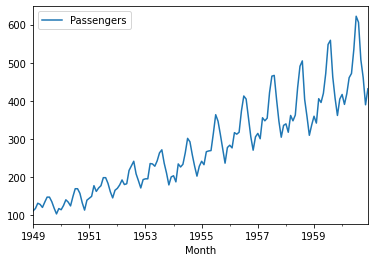

In [3]:
df.plot()

In [4]:
# Calculate the first difference in the data - using diff function instead of shift()

df['1stdiff'] = df['Passengers'].diff()

In [5]:
df.head()

,Passengers,1stdiff
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


<AxesSubplot:xlabel='Month'>

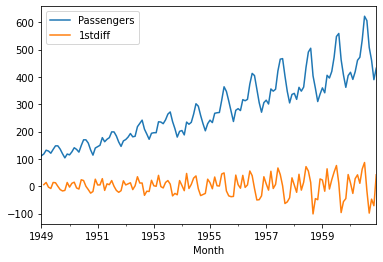

In [6]:
# Plot to see the first_diff - Note this is not stationary as the first_diff still shows seasonality.

df.plot()

<AxesSubplot:xlabel='Month'>

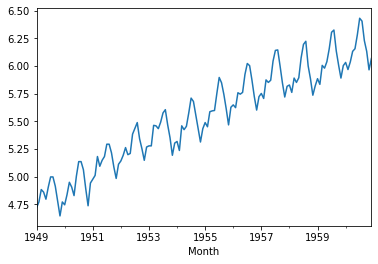

In [7]:
# Calculate the log of the Passengers column and plot - Note the peaks/troughs aren't as extreme on the log amount

df['LogPassengers'] = np.log(df['Passengers'])
df['LogPassengers'].plot()

In [8]:
from statsmodels.tsa.arima_model import ARIMA

In [9]:
# Set frequency of df to Months - Split data into train/test with last 12 months being the testing set.

df.index.freq = 'MS'

Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [10]:
# Create and test an AR(1, 0, 0) model (current value in the time series depends linearly on just the previous value)

arima = ARIMA(train['Passengers'], order=(1,0,0))

c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [11]:
# Fit data to Model - returns an ARIMA obj (not a model)

arima_result = arima.fit()

In [12]:
# Obtain the training predictions and add to the df

df.loc[:-Ntest, 'AR(1)'] = arima_result.predict(start=train.index[0], end=train.index[-1])

<ipython-input-12-1341743e02ae>:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-Ntest, 'AR(1)'] = arima_result.predict(start=train.index[0], end=train.index[-1])


<AxesSubplot:xlabel='Month'>

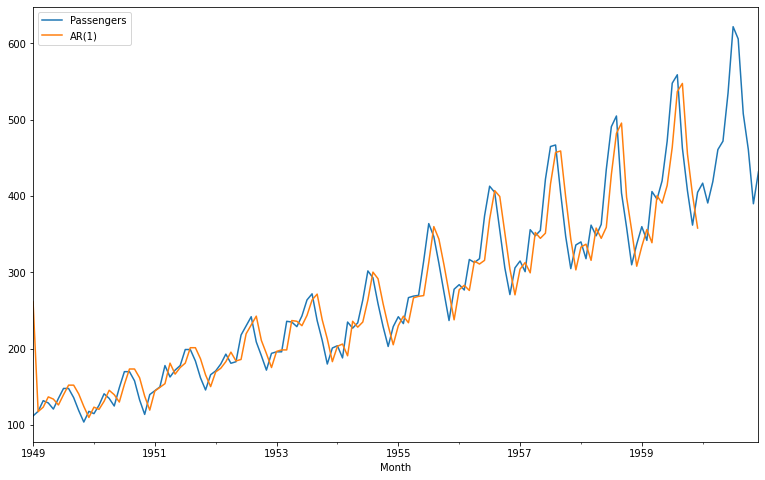

In [13]:
# Plot the Passengers column and the AR(1) column to see how well the fit is between them

df[['Passengers', 'AR(1)']].plot(figsize=(13,8))

In [14]:
# Get the out-of-sample prediction variables for future use - Assign the forecasted values to the AR(1) col

forecast, stderr, confint = arima_result.forecast(Ntest)
df.loc[-Ntest:, 'AR(1)'] = forecast

<ipython-input-14-119a8dfe6d0a>:4: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-Ntest:, 'AR(1)'] = forecast


Text(0.5, 1.0, 'Passengers vs. AR(1, 0, 0)\n\nA reall bad prediction model. Prediction shows it going in the complete wrong direction.')

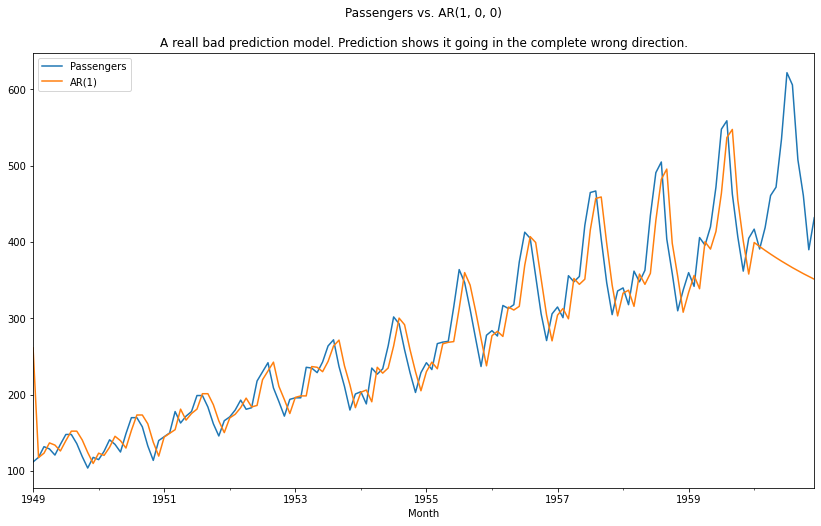

In [15]:
# Plotting Passengers and AR(1) now that the AR(1) line should be completed.

df[['Passengers', 'AR(1)']].plot(figsize=(14,8))
plt.title("Passengers vs. AR(1, 0, 0)\n\nA reall bad prediction model. Prediction shows it going in the complete wrong direction.")

In [16]:
# A function that will plot the fitted values of an ARIMA model with the forecast and confidence intervals (should save on typing)

def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(df['Passengers'], label='data')

    # plot the curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train.index, train_pred, color='green', label='fitted')

    # forecast the test set
    forecast, stderr, confint = result.forecast(Ntest)
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.3, label='confidence')
    ax.legend()

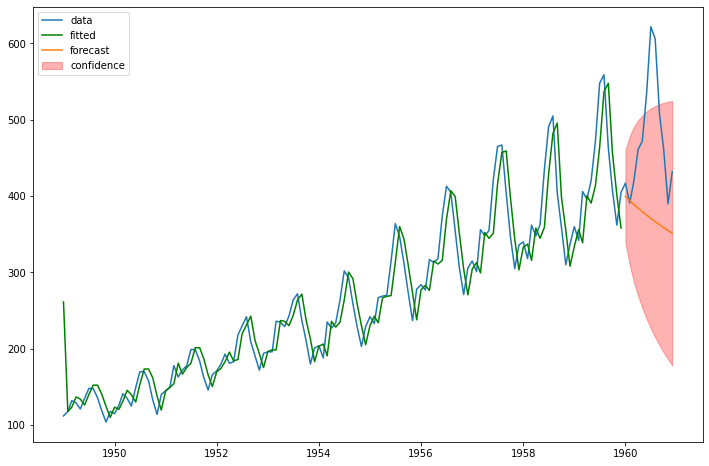

In [17]:
# Test the function with the arima result obj from earlier

plot_fit_and_forecast(arima_result)

c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Text(0.5, 1.0, 'ARIMA(10,0,0) Model\n\nMuch better fit than the (1,0,0) model. Did not anticipate the large seasonal spike though...')

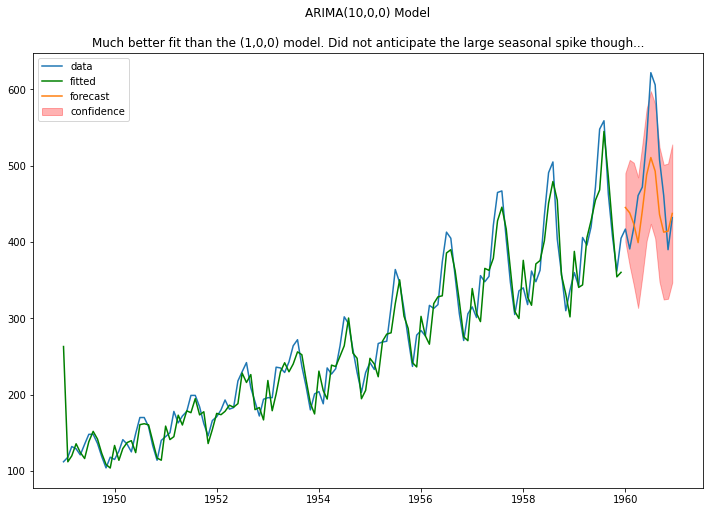

In [18]:
# Since the model is really bad, let's add more (10 total) inputs

arima = ARIMA(train['Passengers'], order=(10,0,0))  # AR(10)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)
plt.title("ARIMA(10,0,0) Model\n\nMuch better fit than the (1,0,0) model. Did not anticipate the large seasonal spike though...")

c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Text(0.5, 1.0, 'ARIMA(0,0,1) Model\n\nClearly an MA(1) model does not work.')

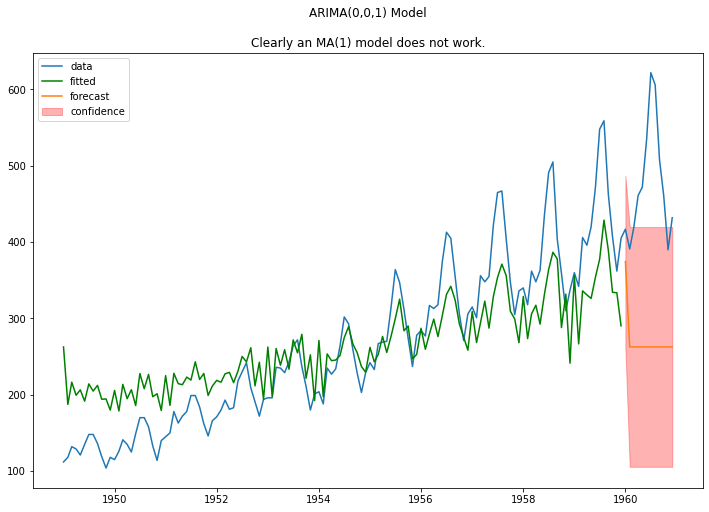

In [19]:
# Testing an MA(0,0,1) model

arima = ARIMA(train['Passengers'], order=(0,0,1)) # MA(1)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)
plt.title("ARIMA(0,0,1) Model\n\nClearly an MA(1) model does not work.")

Investigating the ARIMA model with our data using the **log** scale

Text(0.5, 1.0, 'Log diff (1st) of Passengers\nNot much change overtime (as expected)')

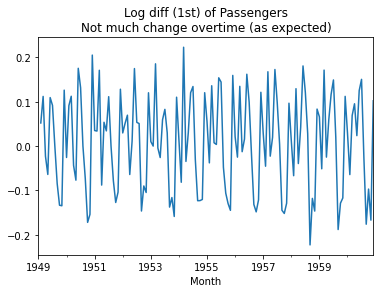

In [20]:
# Getting the first diff of the log passengers

df['Log1stDiff'] = df['LogPassengers'].diff()
df['Log1stDiff'].plot()
plt.title("Log diff (1st) of Passengers\nNot much change overtime (as expected)")

In [21]:
# Fitting a new model on the non-log passengers using differencing (to remove any trend)
# ARIMA(8,1,1) - p=8 because higher seems to be better, d=1 to remove the trend, q=1 for good measure

arima = ARIMA(train['Passengers'], order=(8,1,1))
arima_result_811 = arima.fit()

c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning

In [22]:
# A new function to plot a differenced model (since differencing removes the first row, old func won't work)

def plot_fit_and_forecast_int(result, d, col='Passengers'):
    """Plot resulting ARIMA model adjusted for differencing.
    
    result: the ARIMA result
    d: value of d in ARIMA constructor - represents the first row of missing data in differenced data
    col: column to fit the model on - default to 'Passengers'
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(df[col], label='data')

    # plot the curve fitted on train set
    train_pred = result.predict(start=train.index[d], end=train.index[-1], typ='levels')

    ax.plot(train.index[d:], train_pred, color='green', label='fitted')

    # forecast the test set
    forecast, stderr, confint = result.forecast(Ntest)
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.3)
    ax.legend()

Text(0.5, 1.0, 'ARIMA(8,1,1) Passengers - Results\n\nStill under-representing the peak and over-representing the trough')

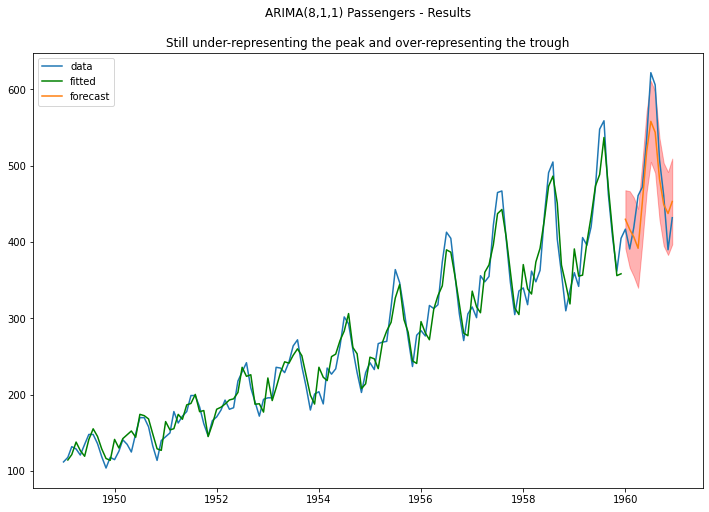

In [23]:
# Use plotting function to plot the ARIMA(8,1,1) results

plot_fit_and_forecast_int(arima_result_811, 1)
plt.title("ARIMA(8,1,1) Passengers - Results\n\nStill under-representing the peak and over-representing the trough")

In [24]:
# Create a function to plot the fit of the model on the differenced series

def plot_difference(result, d, col='Passengers'):
    """ Shows how well the ARMA model fits the data
        result: the ARIMA result
        d: value of d in ARIMA constructor - represents the first row of missing data in differenced data
        col: column to fit the model on - default to 'Passengers'
    """
    train_pred = result.predict(start=train.index[d], end=train.index[-1])  # No typ='levels' 
    # train_pred = result.fittedvalues

    diff = df[col].diff()
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(diff, label='true 1st difference')
    ax.plot(train_pred, label='fitted 1st difference')

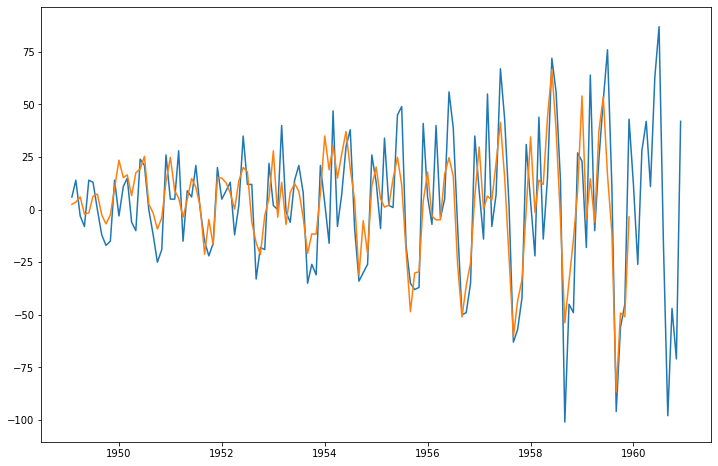

In [25]:
# Use plot_difference function to show the fit of the ARIMA model on the NON-LOGGED Passengers

plot_difference(arima_result_811, 1)

c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning

Text(0.5, 1.0, 'ARIMA(8,1,1) Log_Passengers Results\n\nSeems to do better than on the non-logged reults')

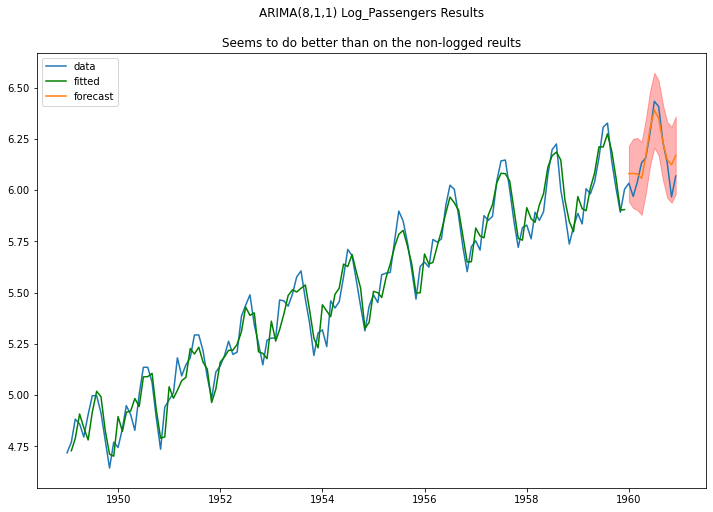

In [26]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

# Create, fit, & plot an ARIMA model with (8,1,1) order on the log_passengers data

arima = ARIMA(train['LogPassengers'], order=(8,1,1))
arima_result_log811 = arima.fit()
plot_fit_and_forecast_int(arima_result_log811, 1, col='LogPassengers')
plt.title("ARIMA(8,1,1) Log_Passengers Results\n\nSeems to do better than on the non-logged reults")

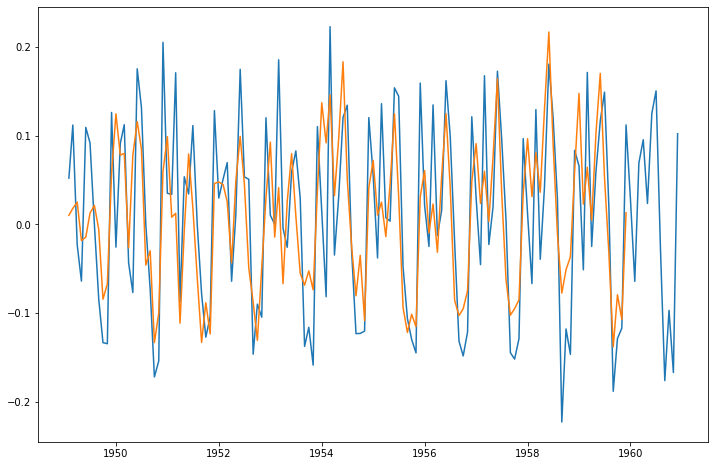

In [27]:
# See the plot difference (func) on the log dataset

plot_difference(arima_result_log811, 1, col='LogPassengers')

## ARIMA(12,1,0)

Testing Log Passengers on an ARIMA(12,1,0) order
- Since using monthly data, a 12 month set of data may be useful.

c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Text(0.5, 1.0, 'ARIMA(12,1,0) LogPassengers Results\n\nThis appears to be the best model so far.')

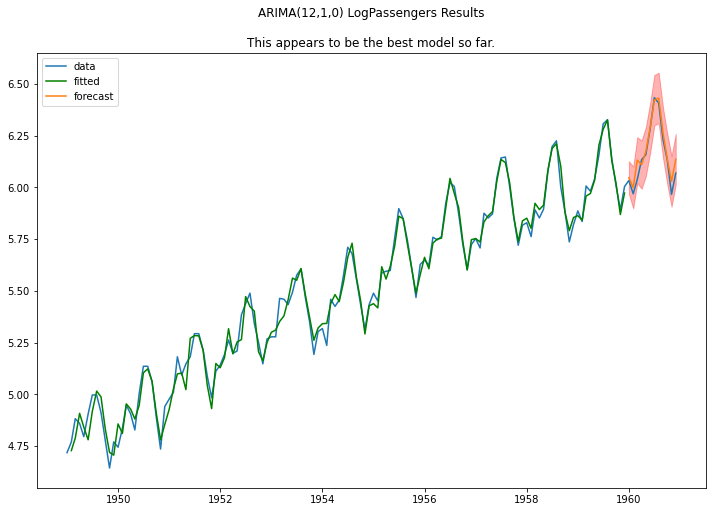

In [28]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)
                        
arima = ARIMA(train['LogPassengers'], order=(12,1,0))
arima_result_log1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_log1210, 1, col='LogPassengers')
plt.title("ARIMA(12,1,0) LogPassengers Results\n\nThis appears to be the best model so far.")

In [29]:
# Create a function that will calculate the Root Mean Square Error results

def rmse(result, is_logged):
    """Returns a Root Mean Square Error result from an ARIMA model
    
    result: ARIMA fit results
    is_logged: Booleen, wheather or not the data is logrythmic
    """
    forecast, stderr, confint = result.forecast(Ntest)
    if is_logged:
        forecast = np.exp(forecast)

    t = test['Passengers']
    y = forecast
    return np.sqrt(np.mean((t - y)**2))

In [30]:
print("ARIMA(8,1,1):", rmse(arima_result_811, False))
print("ARIMA(8,1,1) logged:", rmse(arima_result_log811, True))
print("ARIMA(12,1,0) logged:", rmse(arima_result_log1210, True))
print("\nThe ARIMA(12,1,0) model was indeed the best fitting model for our datasets.")

ARIMA(8,1,1): 38.55069581616873
ARIMA(8,1,1) logged: 32.22406285038859
ARIMA(12,1,0) logged: 18.612097205506362

The ARIMA(12,1,0) model was indeed the best fitting model for our datasets.
